In [63]:
import numpy as np
import os
from keras.models import Model
from keras import layers

import tensorflow as tf

In [64]:
def _parse_function(proto):

    keys_to_features = {'sound': tf.FixedLenFeature([], tf.string),
                        "label": tf.FixedLenFeature([], tf.float32)}
    
    # Load one example
    parsed_features = tf.parse_single_example(proto, keys_to_features)
    
    # Turn the sound string back into an array
    parsed_features['sound'] = tf.decode_raw(parsed_features['sound'], tf.float32)
    
    
    return parsed_features['sound'], parsed_features["label"]

In [65]:
def create_dataset(filepath, classification=True):
    
    files = [filepath + "/" + file for file in os.listdir(filepath)]

    dataset = tf.data.TFRecordDataset(files)
    
    # Maps the parser on every filepath in the array. You can set the number of parallel loaders here
    dataset = dataset.map(_parse_function, num_parallel_calls=4)
    
    # This dataset will go on forever
    dataset = dataset.repeat()
    
    # Set the number of datapoints you want to load and shuffle 
    dataset = dataset.shuffle(250)
    
    # Set the batchsize
    dataset = dataset.batch(batchsize)
    
    # Create an iterator
    iterator = dataset.make_one_shot_iterator()
    
    # Create your tf representation of the iterator
    sound, label = iterator.get_next()

    # reshape
    sound = tf.reshape(sound, [-1, 24000, 1])
    label = tf.reshape(label, [-1, 1])
    
#     Create a one hot array for your labels
#     label = tf.one_hot(label, NUM_CLASSES)

    
    return sound, label

In [66]:
train_filepath = "./data/tf_data/train"
validation_filepath = "./data/tf_data/validation"
batchsize = 16
epochs = 5
train_samples = sum([int(file.split("_")[0]) for file in os.listdir(train_filepath)])
train_samples

5037

In [67]:
val_samples = sum([int(file.split("_")[0]) for file in os.listdir(validation_filepath)])
val_samples

0

In [68]:
sound, label = create_dataset(train_filepath)

In [69]:
val_sound, val_label = create_dataset(validation_filepath)

# Model

In [76]:
# inputs = layers.Input(shape=(data.shape[1],1))
inputs = layers.Input(tensor=sound)

conv1 = layers.Conv1D(filters=64, kernel_size=129, padding="same")(inputs)
pool1 = layers.MaxPool1D(8)(conv1)

reshape = layers.Reshape((3000,64,1))(pool1)

conv2 = layers.Conv2D(filters=96, kernel_size=(61,1), padding="same", activation='relu')(reshape)
pool2 = layers.MaxPool2D((8,1))(conv2)
conv3 = layers.Conv2D(filters=128, kernel_size=(35,1), padding="same", activation='relu')(pool2)
pool3 = layers.MaxPool2D((4,1))(conv3)
conv4 = layers.Conv2D(filters=160, kernel_size=(17,1), padding="same", activation='relu')(pool3)
pool4 = layers.MaxPool2D((12,1))(conv4)
avgpool = layers.AveragePooling2D((5,1))(pool4)

flatten = layers.Flatten()(avgpool)

dense1 = layers.MaxoutDense(output_dim=128,nb_feature=4)(flatten)
#dropout1 = layers.Dropout(0.5)(dense1)
dense2 = layers.MaxoutDense(output_dim=64, nb_feature=4)(dense1)
#dropout2 = layers.Dropout(0.5)(dense2)

# max_out = maximum([Dense(neurons, **dense_args)(input_layer) for _ in range(n_pieces)])

output = layers.Dense(1, activation="sigmoid")(dense2)

In [77]:
model = Model(inputs=inputs, outputs=output)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         (None, 24000, 1)          0         
_________________________________________________________________
conv1d_6 (Conv1D)            (None, 24000, 64)         8320      
_________________________________________________________________
max_pooling1d_6 (MaxPooling1 (None, 3000, 64)          0         
_________________________________________________________________
reshape_6 (Reshape)          (None, 3000, 64, 1)       0         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 3000, 64, 96)      5952      
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 375, 64, 96)       0         
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 375, 64, 128)      430208    
__________

In [61]:
model.compile(optimizer='Adam',
              loss='binary_crossentropy',
              metrics=['accuracy'],
              target_tensors=[label])

In [62]:
epochs=50
batchsize=512
history = model.fit(epochs=epochs,
                    steps_per_epoch=int(train_samples/batchsize),
                    validation_data=(val_sound, val_label),
                    validation_steps=int(val_samples/batchsize))

Epoch 1/50
104/104 [==============================] - 975s 9s/step - loss: 0.6815 - acc: 0.5986 - val_loss: 0.6451 - val_acc: 0.6602
Epoch 2/50
104/104 [==============================] - 971s 9s/step - loss: 0.6387 - acc: 0.6803 - val_loss: 0.6803 - val_acc: 0.5391
Epoch 3/50
104/104 [==============================] - 971s 9s/step - loss: 0.6391 - acc: 0.6490 - val_loss: 0.6278 - val_acc: 0.6758
Epoch 4/50
104/104 [==============================] - 973s 9s/step - loss: 0.6328 - acc: 0.6605 - val_loss: 0.6277 - val_acc: 0.6445
Epoch 5/50
104/104 [==============================] - 972s 9s/step - loss: 0.6440 - acc: 0.6412 - val_loss: 0.6074 - val_acc: 0.7305
Epoch 6/50
104/104 [==============================] - 973s 9s/step - loss: 0.6674 - acc: 0.6088 - val_loss: 0.6112 - val_acc: 0.6953
Epoch 7/50
104/104 [==============================] - 972s 9s/step - loss: 0.6446 - acc: 0.6346 - val_loss: 0.6367 - val_acc: 0.6484
Epoch 8/50
104/104 [==============================] - 973s 9s/step - 

KeyboardInterrupt: 

In [49]:
history_old = history

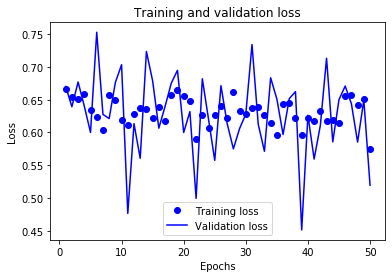

In [74]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

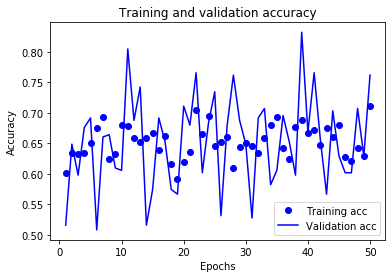

In [75]:
history_dict = history.history
plt.clf()   # clear figure
acc_values = history_dict['acc']
val_acc_values = history_dict['val_acc']

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [105]:
# x_train = data.reshape((data.shape[0], data.shape[1], 1))

In [106]:
# x_train.shape

In [1]:
# history = model.fit(x_train, 
#                     labels,
#                     batch_size=32,
#                     epochs=5,
#                     validation_split=0.1)

In [ ]:
# from tensorflow.python.client import device_lib
# print(device_lib.list_local_devices())

In [17]:
import torch

In [18]:
from torch import cuda
assert cuda.is_available()
assert cuda.device_count() > 0
print(cuda.get_device_name(cuda.current_device()))

GeForce GTX 1050 Ti


In [3]:
tf.test.is_gpu_available()

True